In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../Lab1/fulldata.csv")
data.head()

,Unnamed: 0,lat_,lon_,State_,Ta_mean,Ta_min,Ta_max,Tsurf_mean,Tsurf_min,Tsurf_max,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,0,68.0926,16.3644,3,14.1,14.1,14.1,1.675000,1.61,1.74,...,36,63,69,0.0,1000,-5,10,152,17,kjopsvik
1,1,68.0926,16.3645,3,14.1,14.1,14.1,1.787778,1.55,1.98,...,36,63,69,0.0,1000,-5,10,152,17,kjopsvik
2,2,68.0926,16.3646,3,14.1,14.1,14.1,2.050000,2.05,2.05,...,36,63,69,0.0,1000,-5,10,152,17,kjopsvik
3,3,68.0926,16.3647,3,14.1,14.1,14.1,1.920000,1.92,1.92,...,36,63,69,0.0,1000,-5,10,152,17,kjopsvik
4,4,68.0926,16.3648,3,14.1,14.1,14.1,1.550000,1.55,1.55,...,36,63,69,0.0,1000,-5,10,152,17,kjopsvik


In [3]:
datas = data.sort_values(by = ['Date', 'Time'])

In [4]:
datas.head()

,Unnamed: 0,lat_,lon_,State_,Ta_mean,Ta_min,Ta_max,Tsurf_mean,Tsurf_min,Tsurf_max,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
159111,159111,68.4516,17.5419,3,11.487162,2.6,15.3,2.378784,-0.04,4.35,...,30,51,72,0.0,1007,1,10,149,15,oyjord
159112,159112,68.4516,17.5422,3,16.359036,2.9,19.5,4.018675,-1.14,5.91,...,30,51,72,0.0,1007,1,10,149,15,oyjord
159116,159116,68.4516,17.5426,3,14.879070,-6.4,19.7,3.796744,-7.30,6.31,...,30,51,72,0.0,1007,1,10,149,15,oyjord
159115,159115,68.4516,17.5425,3,18.413559,2.9,19.7,5.139068,0.10,6.28,...,30,51,72,0.0,1007,1,10,149,15,oyjord
159114,159114,68.4516,17.5424,3,15.258537,2.9,19.5,3.798537,-0.80,6.40,...,30,51,72,0.0,1007,1,10,149,15,oyjord


In [5]:
predictors = ['Height_mean', 'Speed_mean']
target = ['Friction_mean', 'Water_mean', 'Tsurf_mean']

In [6]:
datas['Time'].info

<bound method Series.info of 159111    06:51:34
159112    06:54:50
159116    06:55:02
159115    06:55:05
159114    06:55:06
            ...   
95245     15:22:00
95247     15:22:02
95248     15:22:04
95249     15:22:05
95250     15:22:06
Name: Time, Length: 196133, dtype: object>

In [7]:
pd.to_datetime(datas['date_time'])

159111   2020-11-30 06:00:00
159112   2020-11-30 06:00:00
159116   2020-11-30 06:00:00
159115   2020-11-30 06:00:00
159114   2020-11-30 06:00:00
                 ...        
95245    2021-03-03 15:00:00
95247    2021-03-03 15:00:00
95248    2021-03-03 15:00:00
95249    2021-03-03 15:00:00
95250    2021-03-03 15:00:00
Name: date_time, Length: 196133, dtype: datetime64[ns]

In [8]:
def getDateTime(row):
    return '-'.join(row['Date'].split('.')) + " " + row['Time']

In [9]:
times = pd.to_datetime(datas.apply(getDateTime, axis=1))

In [10]:
datas['times'] = times
datas_subs = datas[['times']+target+predictors]

In [11]:
fdata = datas_subs.resample("180S", on = 'times').mean()[:300]

In [12]:
fdata.reset_index(inplace=True)

In [13]:
fdata.head()

,times,Friction_mean,Water_mean,Tsurf_mean,Height_mean,Speed_mean
0,2020-11-30 06:51:00,0.668041,0.348270,2.378784,119.716216,1.015541
1,2020-11-30 06:54:00,0.657400,0.396293,0.886534,111.842536,22.251895
2,2020-11-30 06:57:00,0.674035,0.253542,0.276387,66.135803,43.086703
3,2020-11-30 07:00:00,0.671570,0.241061,0.615723,54.376604,60.944598
4,2020-11-30 07:03:00,0.685286,0.215836,-0.580710,67.556196,39.791792


По умолчанию тренды приближаем с помощью полиномов 9-ой степени

In [14]:
def rolling_fillna(series: pd.Series, window=5):
    ans = series
    for i in range(window,series.shape[0]):
        ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
    return ans

def determinetrend(data: pd.Series, order=9):
    trend = np.polyfit(data.index.values, data.tolist(), order)
    return np.poly1d(trend)(data.index.values)

Графики рядов с их выученными трендами

C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

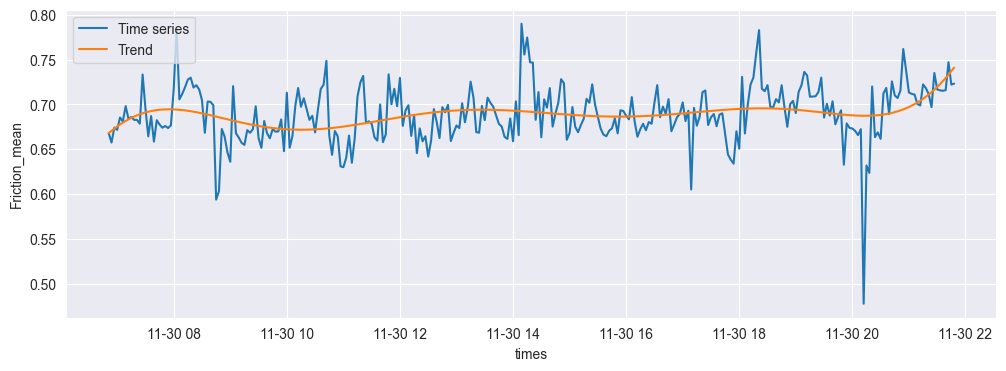

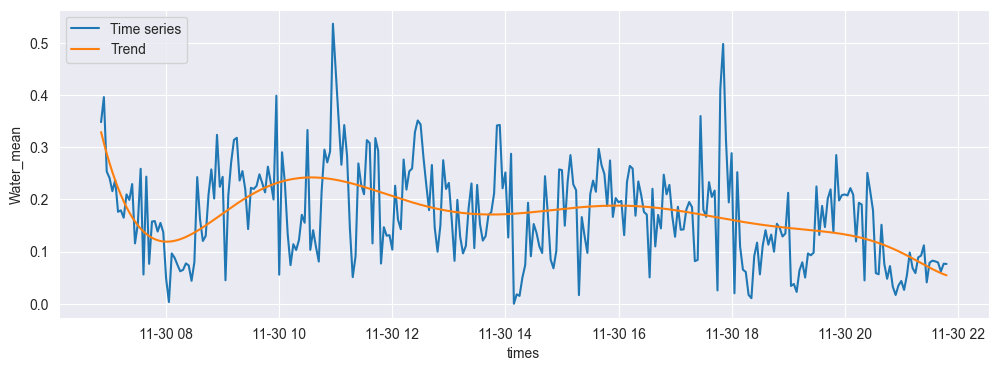

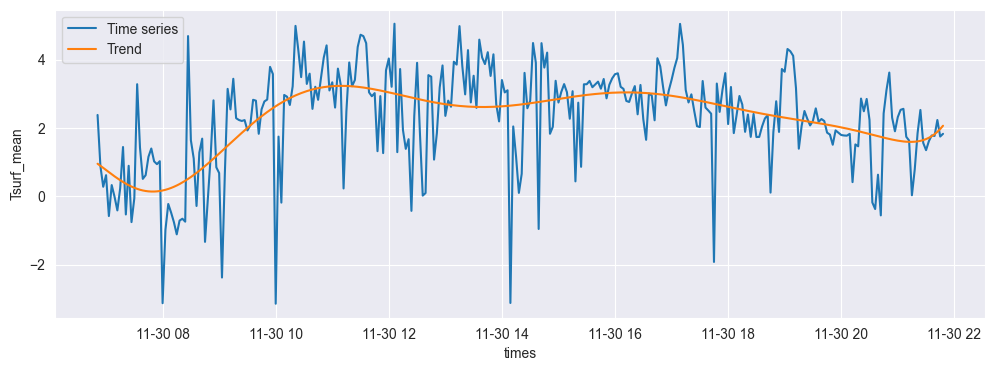

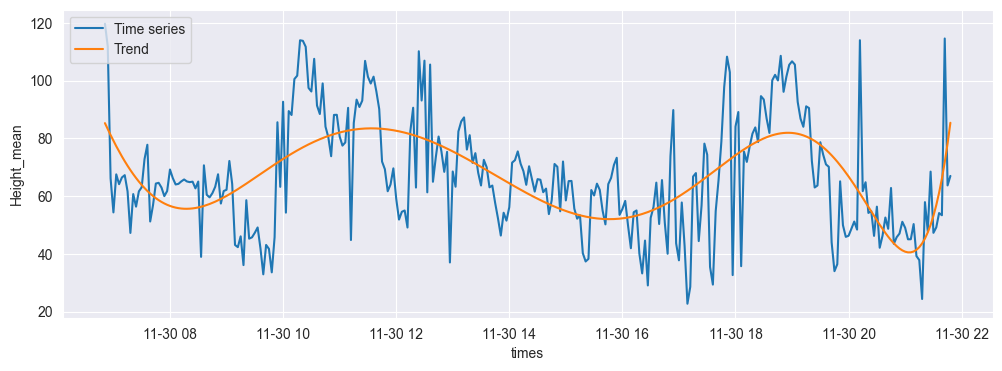

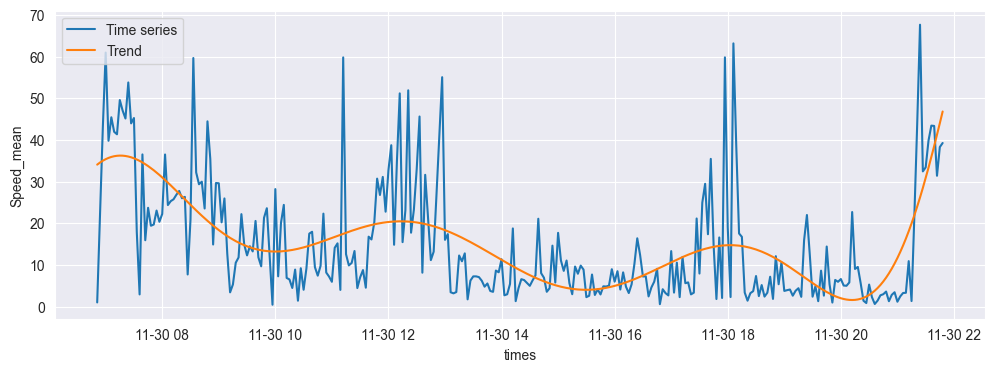

In [15]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    sns.lineplot(x=fdata['times'], y=d, label='Time series')
    sns.lineplot(x=fdata['times'], y=trend, label='Trend')
    plt.legend(loc = 2)

In [16]:
numbers = np.array(list(range(1, 301)), dtype = int)

Присутствие трендов убрано. Здесь смотрим на получившиеся ряды и оценку функции среднего

C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

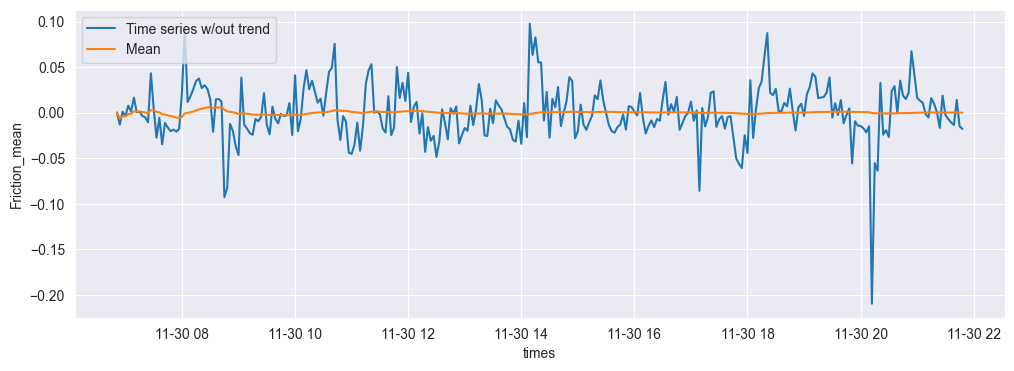

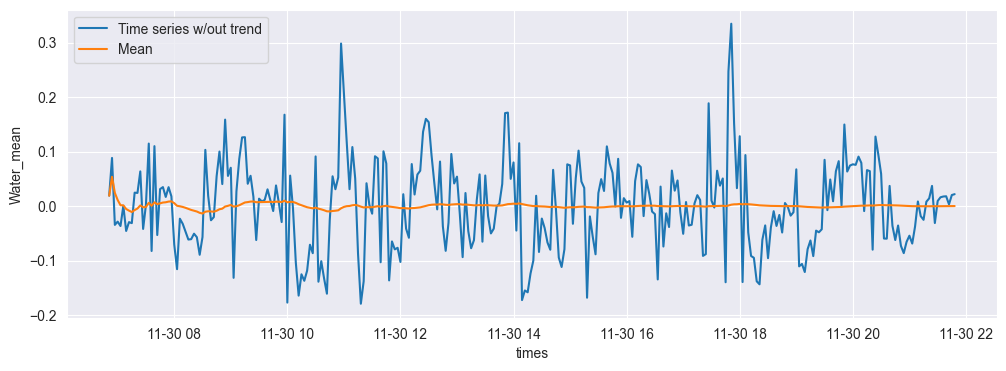

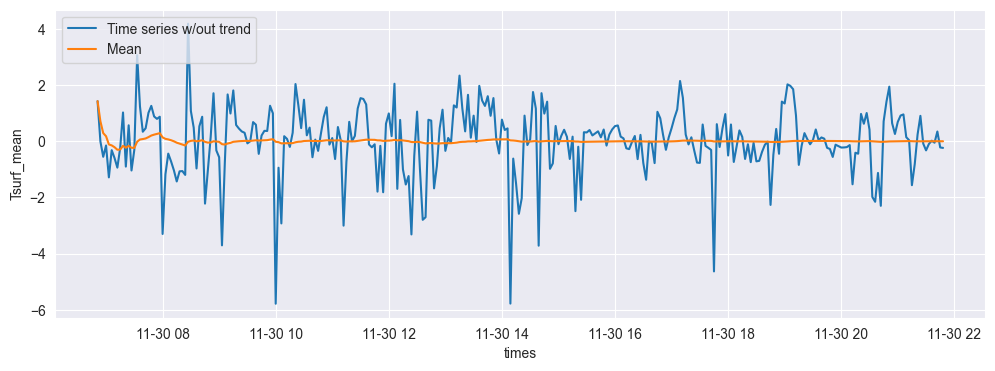

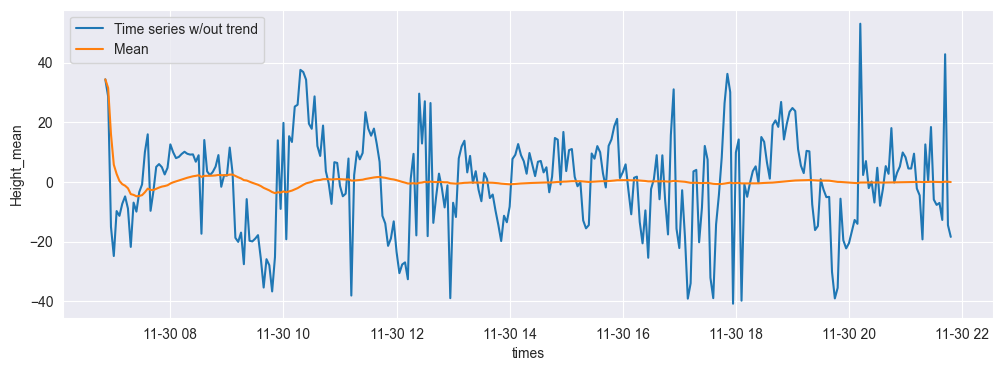

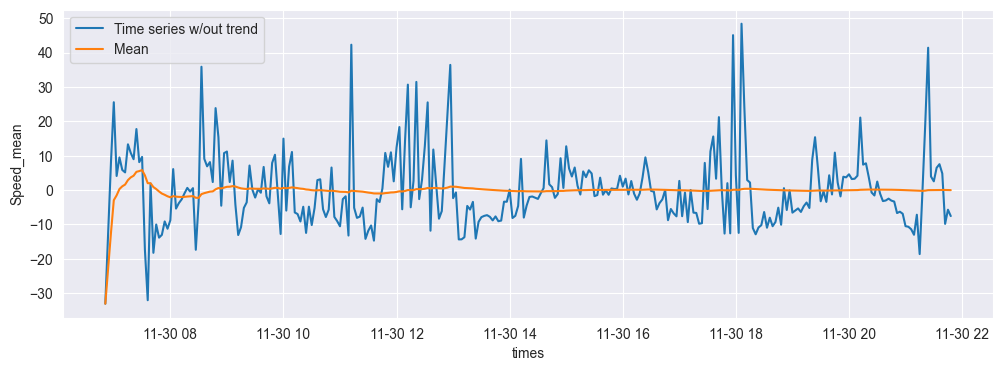

In [17]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    dwout = d - trend

    mean = dwout.cumsum()/numbers

    sns.lineplot(x=fdata['times'], y=dwout, label='Time series w/out trend')
    sns.lineplot(x=fdata['times'], y=mean, label='Mean')
    plt.legend(loc = 2)

Здесь смотрим на функции дисперсии у этих рядов.

C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored 

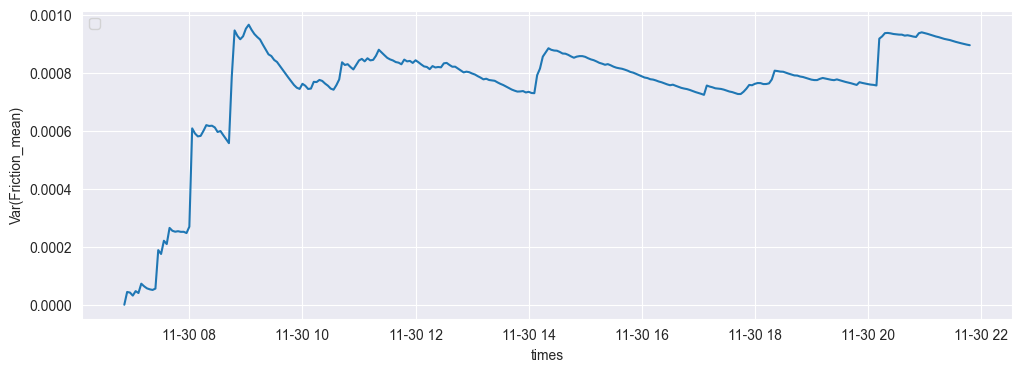

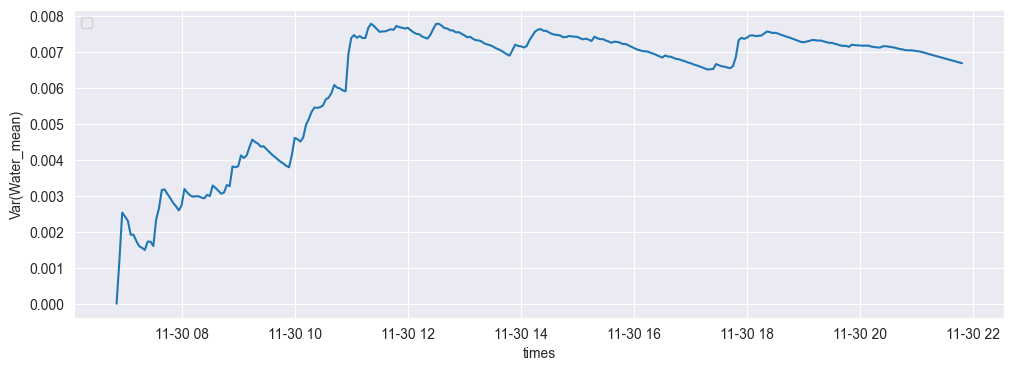

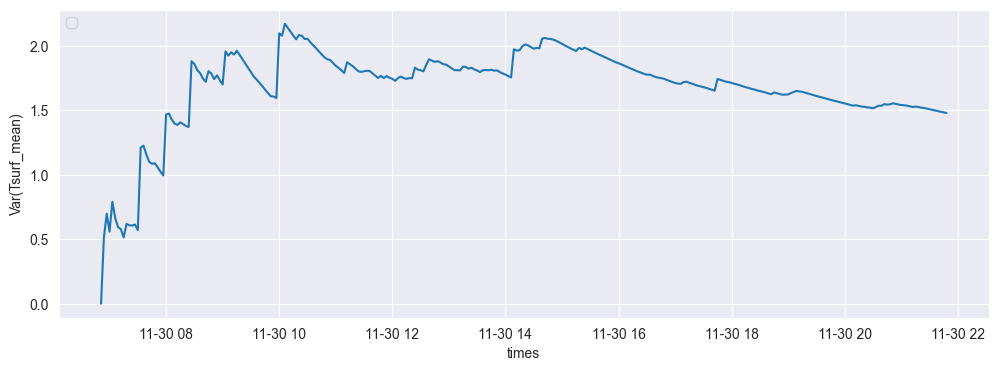

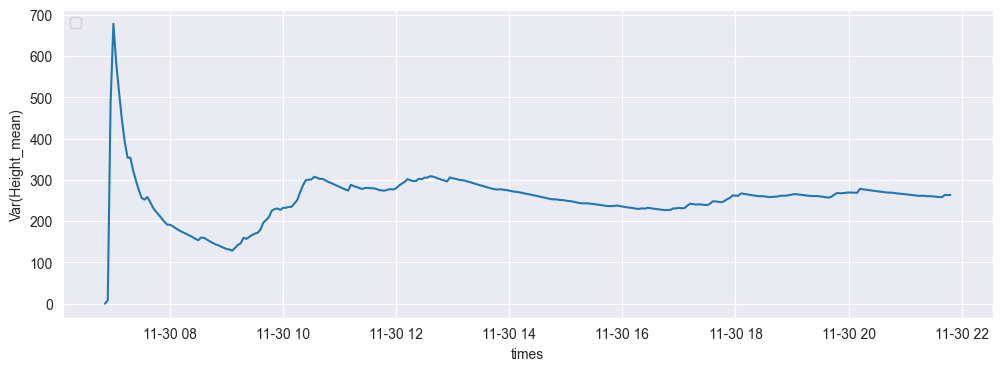

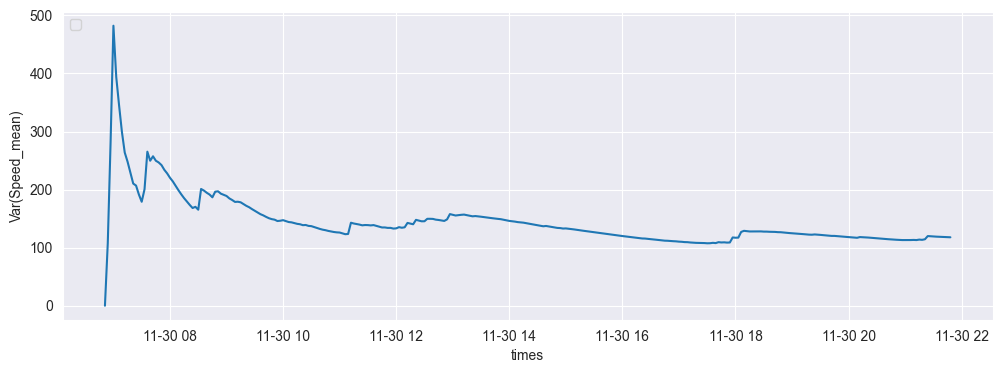

In [23]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    dwout = d - trend

    var = (dwout**2).cumsum()/numbers - (dwout.cumsum()/numbers)**2

    sns.lineplot(x=fdata['times'], y=var)
    plt.ylabel("Var("+feat+")")
    plt.legend(loc = 2)

In [35]:
from statsmodels.tsa.stattools import acf, pacf, acovf, ccovf, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

А здесь на автоковариации

C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored 

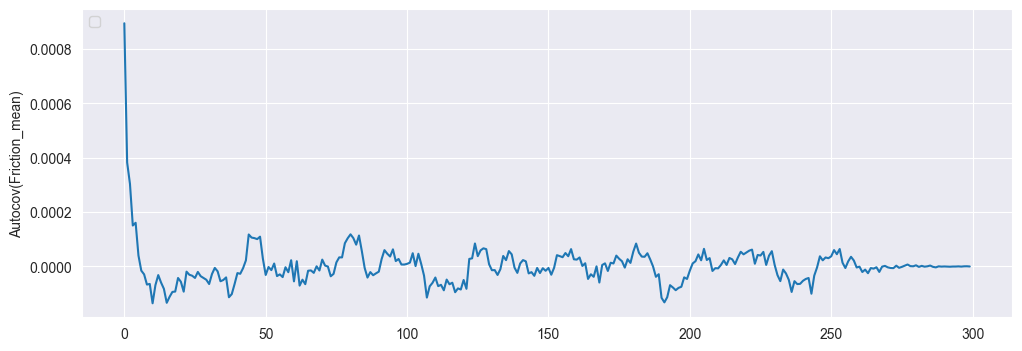

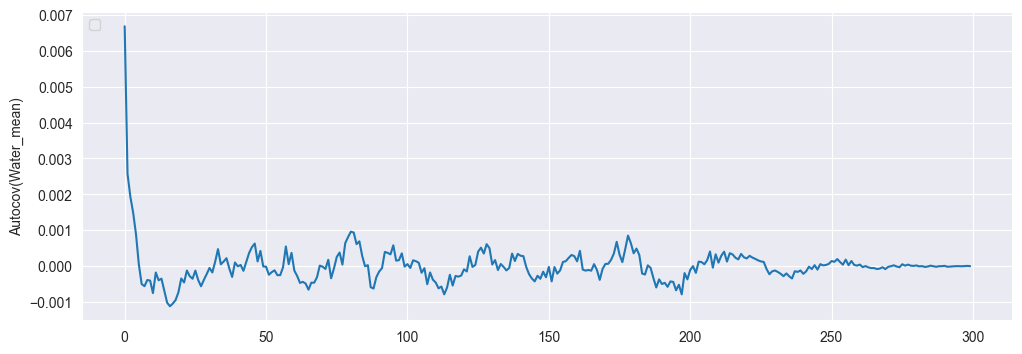

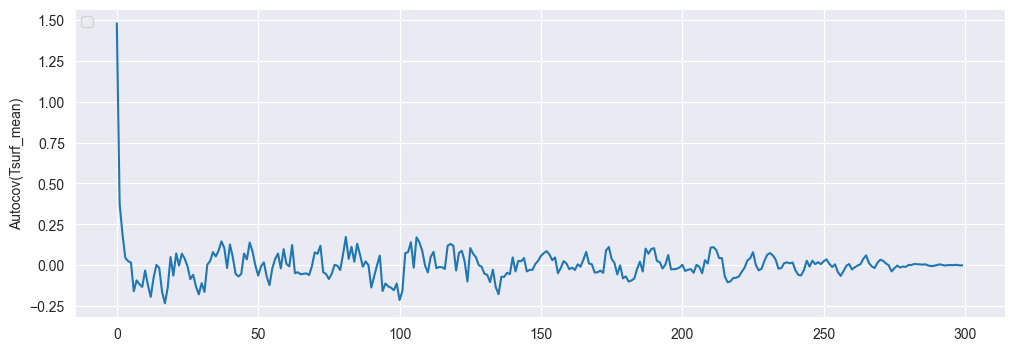

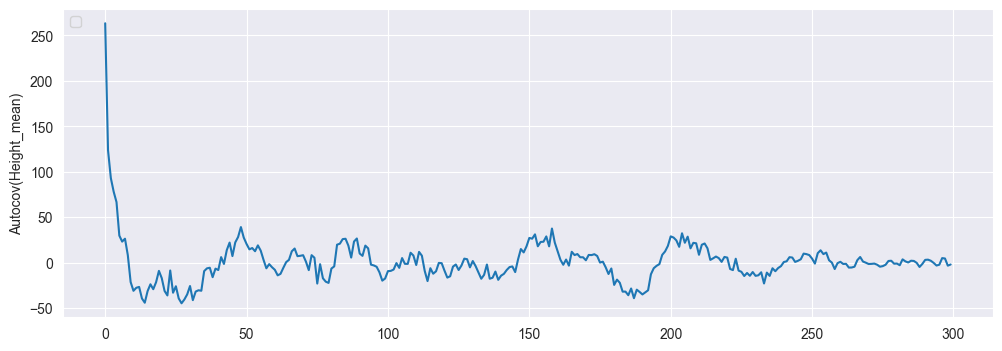

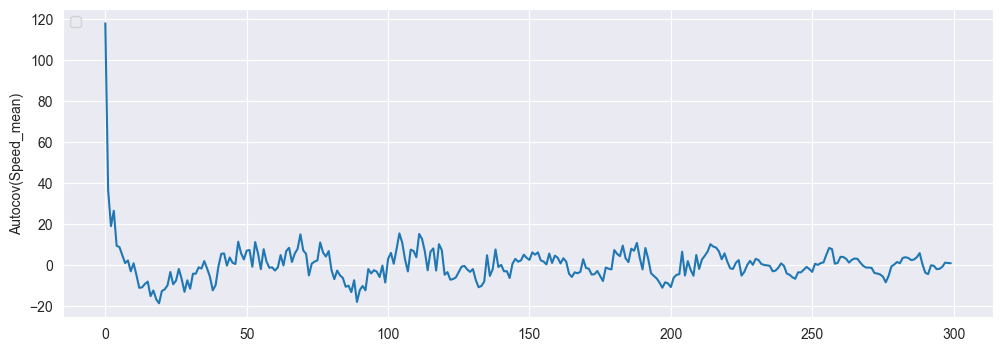

In [20]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    plt.figure(figsize=(12,4), dpi= 100)

    trend = determinetrend(d)

    dwout = d - trend

    sns.lineplot(acovf(dwout, fft=False))
    plt.ylabel("Autocov("+feat+")")
    plt.legend(loc = 2)

In [22]:
from statsmodels.tsa.stattools import adfuller

In [25]:
for feat in target+predictors:
    d = rolling_fillna(fdata[feat])

    trend = determinetrend(d)

    dwout = d - trend
    print(feat)
    print(adfuller(dwout))



C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]
C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

Friction_mean
(-7.550400243488283, 3.2001534854724324e-11, 1, 298, {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}, -1235.5806467878185)
Water_mean
(-6.734103956919638, 3.24023028074298e-09, 5, 294, {'1%': -3.452789844280995, '5%': -2.871421512222641, '10%': -2.5720351510944512}, -656.9743089600452)
Tsurf_mean
(-13.344201647793428, 5.838729978205566e-25, 0, 299, {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}, 902.2161862337447)
Height_mean
(-5.644384629164311, 1.0192376700780344e-06, 4, 295, {'1%': -3.452713099849546, '5%': -2.871387839457783, '10%': -2.5720171933352485}, 2302.0050274030923)
Speed_mean
(-6.831919769583617, 1.884188960281348e-09, 2, 297, {'1%': -3.4525611751768914, '5%': -2.87132117782556, '10%': -2.5719816428028888}, 2098.70846711092)


C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]


In [26]:
trends = dict()
fdata_mod = pd.DataFrame(columns=fdata.columns, index=fdata.index)
fdata_mod['times'] = fdata['times']

for feat in target+predictors:
    d = rolling_fillna(fdata[feat])
    trends[feat] = determinetrend(d)
    fdata_mod[feat] = d - trends[feat]
fdata_mod.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_23384\4178025268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans[i] = ans[(i-window):i].mean() if pd.isna(ans[i]) else ans[i]


,times,Friction_mean,Water_mean,Tsurf_mean,Height_mean,Speed_mean
0,2020-11-30 06:51:00,0.000101,0.019028,1.427731,34.424993,-33.052936
1,2020-11-30 06:54:00,-0.013167,0.088326,-0.004763,28.651617,-12.319931
2,2020-11-30 06:57:00,0.000982,-0.034574,-0.553256,-15.021904,8.078731
3,2020-11-30 07:00:00,-0.003824,-0.028584,-0.151345,-24.818380,25.567747
4,2020-11-30 07:03:00,0.007694,-0.036671,-1.285170,-9.749479,4.113010


Автоковариации с окнами шириной в 30

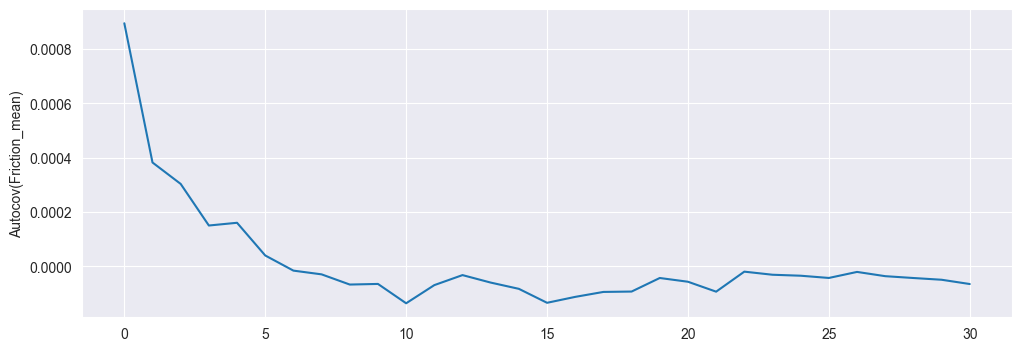

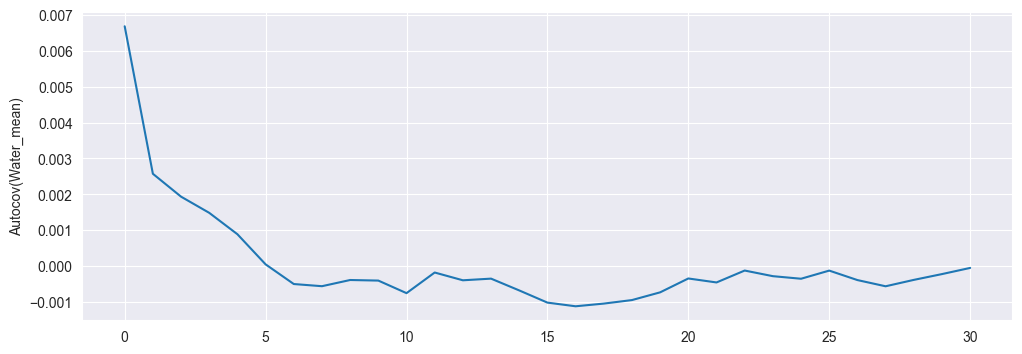

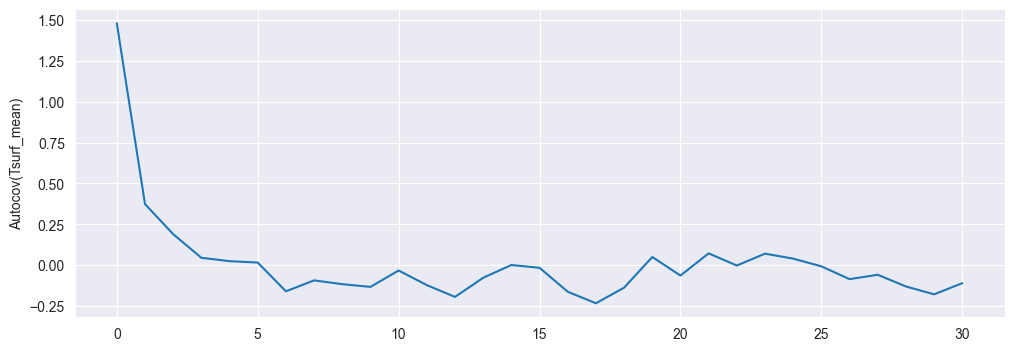

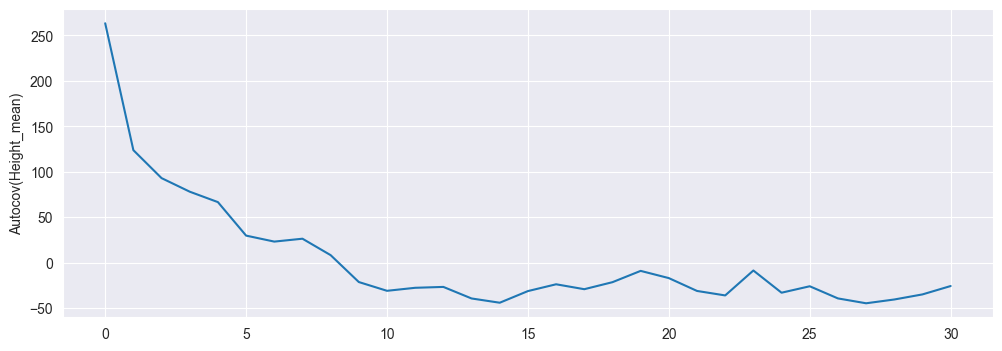

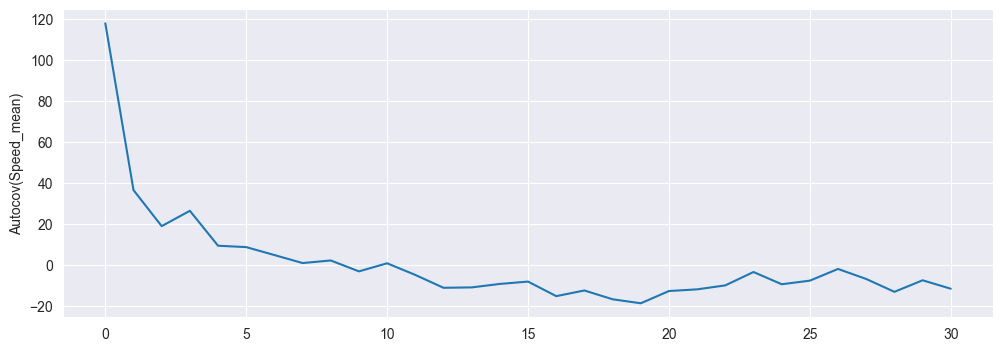

In [30]:
for feat in target+predictors:
    plt.figure(figsize=(12,4), dpi= 100)
    sns.lineplot(acovf(fdata_mod[feat], fft=False, nlag=30))
    plt.ylabel("Autocov("+feat+")")

Кросс-корреляции

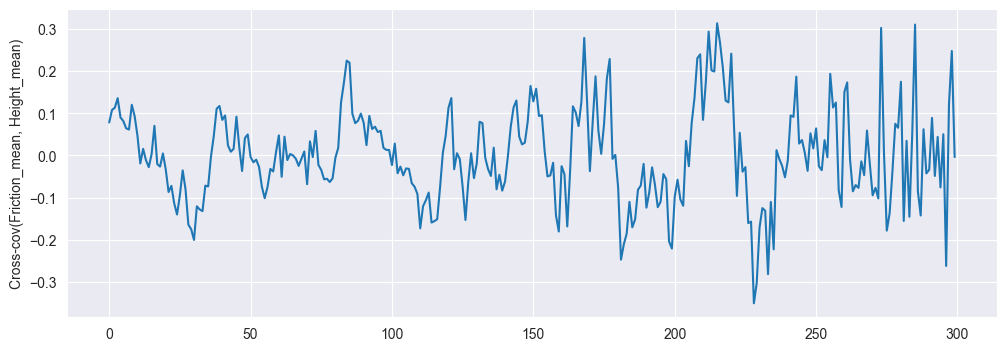

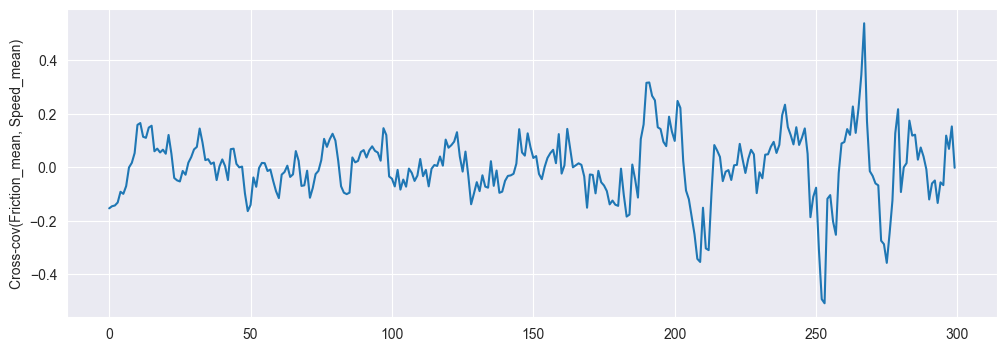

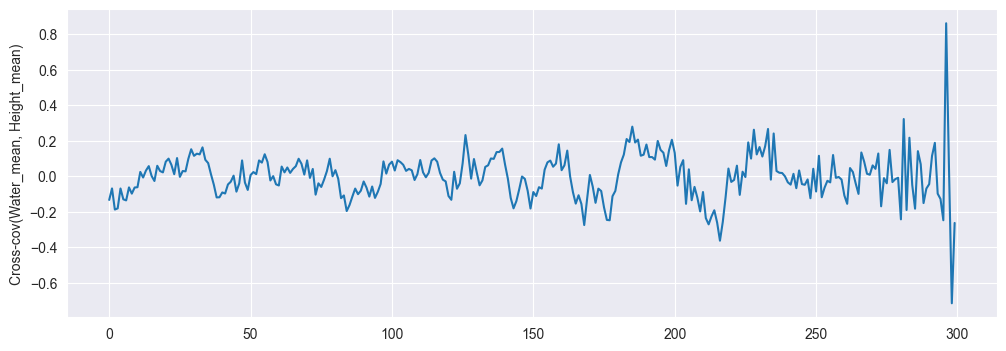

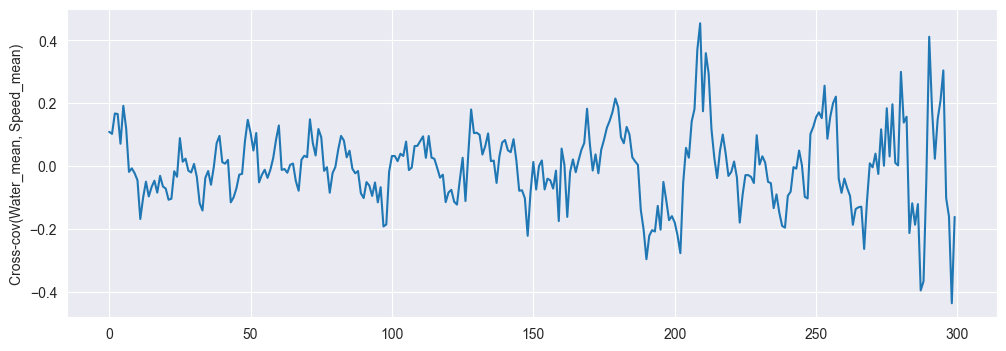

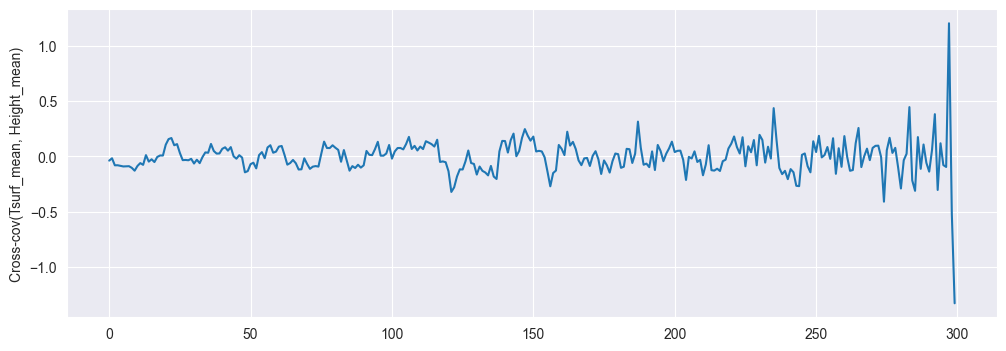

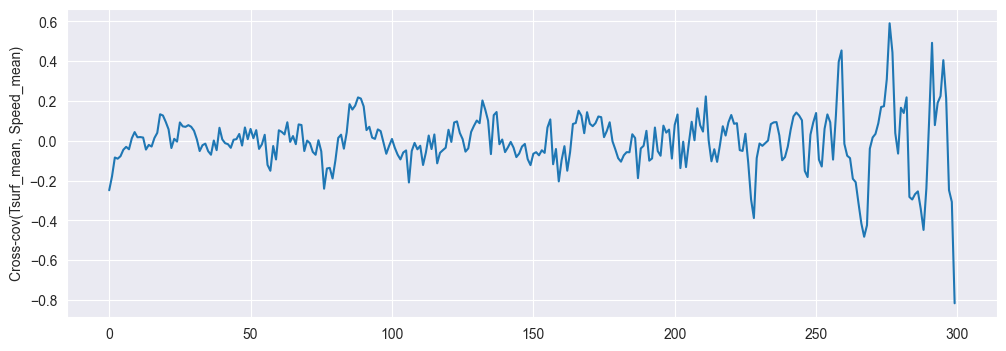

In [36]:
for tar in target:
    for pred in predictors:
        plt.figure(figsize=(12,4), dpi= 100)
        sns.lineplot(ccf(x=fdata_mod[pred], y=fdata_mod[tar], fft=False))
        plt.ylabel("Cross-corr("+tar+", "+pred+")")

In [ ]:
blackman = signal.windows.blackman(M=5)
f, Pxx_den = signal.welch(friction, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
plt.plot(f, Pxx_den, linewidth=4)